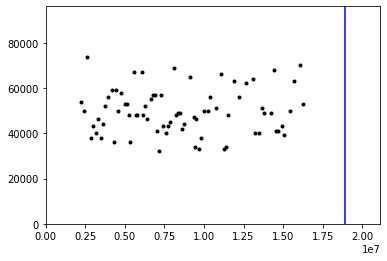

In [48]:
import json
import matplotlib.pyplot as plt
import numpy as np

#with open("data/baby2.json") as datafile:
with open("data/baby1.json") as datafile:
    data_baby1 = json.load(datafile)

time_msec = []
contraction_length_msec = []
for entry in data["contractions"]:
    time_msec.append(entry["startTime"])
    contraction_length_msec.append(entry["duration"])

time_msec = np.array(time_msec)
contraction_length_msec = np.array(contraction_length_msec)
indexes = time_msec.argsort()
time_msec = time_msec[indexes]
contraction_length_msec = contraction_length_msec[indexes]

X_AXIS_BOUNDS = int(max(time_msec)*1.3)
Y_AXIS_BOUNDS = int(max(contraction_length_msec)*1.3)

delivery_time_msec = data["deliveryTime"]
delivery_line_x = []
delivery_line_y = []
for i in range(0, Y_AXIS_BOUNDS, 1000):
  delivery_line_x.append(delivery_time_msec)
  delivery_line_y.append(i)

plt.xlim([0, X_AXIS_BOUNDS])
plt.ylim([0, Y_AXIS_BOUNDS])
plt.plot(time_msec, contraction_length_msec, '.', color='black')
plt.plot(delivery_line_x, delivery_line_y, '-', color='blue')

Steve Mould's video says:
> They are not very predictable. They're quite spread out, but as time goes on it gets more predictable - it's more bunched up there. And there's a wonderful thing you can do with excel. You can track how that changes as a function of time. Is the standard deviation basically. So I was able to create sort of an envelope of possible contraction lengths and then project that into the future. [...] there is point in the future at which my wife's contractions become perfectly regular and that's at 20:55. And it's my working hypothesis that that is the moment my child will be born.

However, I'm not sure how to apply that. My guess is that he used a sliding 'window' and calculated the standard deviation on those windows.

(0.0, 88654.53072070333)

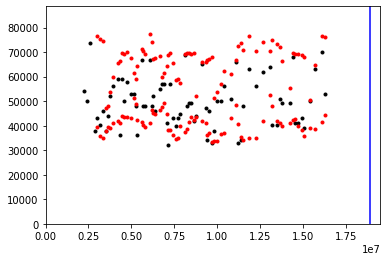

In [49]:

WINDOW_SIZE = 5
NUM_SIGMAS = 2

means = []
standard_devs = []
mean_upper = []
mean_lower = []
windowed_time_msec = time_msec[WINDOW_SIZE-1:len(contraction_length_msec)]
for i in range(WINDOW_SIZE-1, len(contraction_length_msec)):
    contraction_sub_array = contraction_length_msec[i-WINDOW_SIZE+1:i+1]
    mean = np.mean(contraction_sub_array)
    standard_dev = np.std(contraction_sub_array)
    means.append(mean)
    standard_devs.append(standard_dev)
    mean_upper.append(mean+NUM_SIGMAS*standard_dev)
    mean_lower.append(mean+NUM_SIGMAS-standard_dev)

plt.plot(time_msec, contraction_length_msec, '.', color='black')
plt.plot(delivery_line_x, delivery_line_y, '-', color='blue')
plt.plot(windowed_time_msec, mean_upper, '.', color='red')
plt.plot(windowed_time_msec, mean_lower, '.', color='red')
plt.xlim([0, max(time_msec)*1.2])
plt.ylim([0, max(contraction_length_msec)*1.2])



If you plotted a curve through the the upper and lower bounds from 2 std devs from the mean (red dots), it looks like they could intersect near the blue vertical bar (delivery time).

First let's try an exponential model.

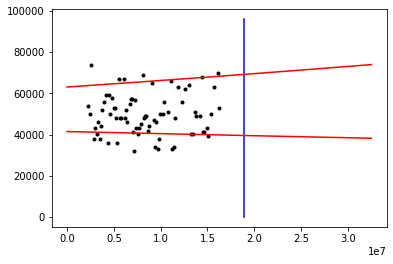

In [50]:
log_mean_upper = np.log(mean_upper)
log_mean_lower = np.log(mean_lower)
log_curve_fit_upper = np.polyfit(windowed_time_msec, log_mean_upper, 1)
log_curve_fit_lower = np.polyfit(windowed_time_msec, log_mean_lower, 1)

projected_time = []
for i in range(0, int(max(time_msec)*2), 1000):
  projected_time.append(i)
projected_time = np.array(projected_time)
exp_mean_upper_projected = np.exp(log_curve_fit_upper[1]) * np.exp(log_curve_fit_upper[0]*projected_time)
exp_mean_lower_projected = np.exp(log_curve_fit_lower[1]) * np.exp(log_curve_fit_lower[0]*projected_time)
plt.plot(time_msec, contraction_length_msec, '.', color='black')
plt.plot(delivery_line_x, delivery_line_y, '-', color='blue')
plt.plot(projected_time, exp_mean_upper_projected, '-', color='red')
plt.plot(projected_time, exp_mean_lower_projected, '-', color='red')

The exponential model didn't intersect in Steve Mould's video.

Now I'm trying to see if a linear model will do better.

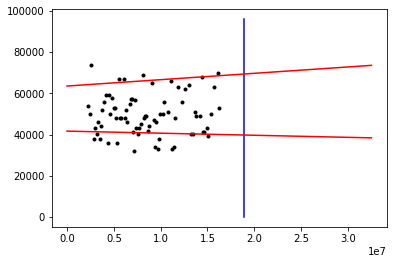

In [51]:
linear_curve_fit_upper = np.polyfit(windowed_time_msec, mean_upper, 1)
linear_curve_fit_lower = np.polyfit(windowed_time_msec, mean_lower, 1)
projected_time = []
for i in range(0, int(max(time_msec)*2), 1000):
  projected_time.append(i)
projected_time = np.array(projected_time)
linear_mean_upper_projected = linear_curve_fit_upper[1] + linear_curve_fit_upper[0]*projected_time
linear_mean_lower_projected = linear_curve_fit_lower[1] + linear_curve_fit_lower[0]*projected_time
plt.plot(time_msec, contraction_length_msec, '.', color='black')
plt.plot(delivery_line_x, delivery_line_y, '-', color='blue')
plt.plot(projected_time, linear_mean_upper_projected, '-', color='red')
plt.plot(projected_time, linear_mean_lower_projected, '-', color='red')

The linear model did not intersect anywhere close to the delivery time.

Trying to do windowed again, but do not repeat. Only keep #points/10 instead of #points-10


(0.0, 88654.53072070333)

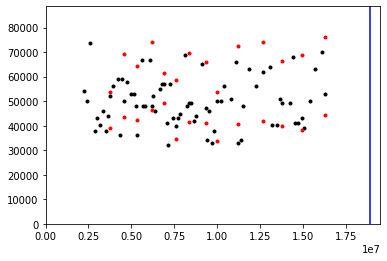

In [52]:
divided_window_means = []
divided_window_standard_devs = []
divided_window_mean_upper = []
divided_window_mean_lower = []
divided_windowed_time_msec = []
for i in range(len(contraction_length_msec)-1, 0, -WINDOW_SIZE):
    if i >= 9:
      contraction_sub_array = contraction_length_msec[i-WINDOW_SIZE+1:i+1]
      mean = np.mean(contraction_sub_array)
      standard_dev = np.std(contraction_sub_array)
      divided_window_means.append(mean)
      divided_window_standard_devs.append(standard_dev)
      divided_window_mean_upper.append(mean+NUM_SIGMAS*standard_dev)
      divided_window_mean_lower.append(mean+NUM_SIGMAS-standard_dev)
      divided_windowed_time_msec.append(time_msec[i])

plt.plot(time_msec, contraction_length_msec, '.', color='black')
plt.plot(delivery_line_x, delivery_line_y, '-', color='blue')
plt.plot(divided_windowed_time_msec, divided_window_mean_upper, '.', color='red')
plt.plot(divided_windowed_time_msec, divided_window_mean_lower, '.', color='red')
plt.xlim([0, max(time_msec)*1.2])
plt.ylim([0, max(contraction_length_msec)*1.2])

Exponential model with divided windows instead of repeated windows:

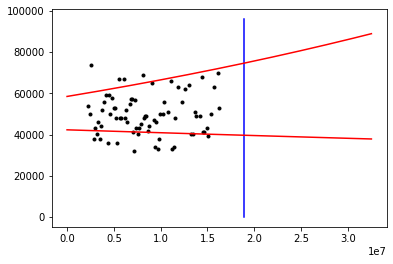

In [53]:
log_divided_window_mean_upper = np.log(divided_window_mean_upper)
log_divided_window_mean_lower = np.log(divided_window_mean_lower)
log_divided_window_curve_fit_upper = np.polyfit(divided_windowed_time_msec, log_divided_window_mean_upper, 1)
log_divided_window_curve_fit_lower = np.polyfit(divided_windowed_time_msec, log_divided_window_mean_lower, 1)

projected_time = []
for i in range(0, int(max(time_msec)*2), 1000):
  projected_time.append(i)
projected_time = np.array(projected_time)

exp_divided_window_mean_upper_projected = np.exp(log_divided_window_curve_fit_upper[1]) * np.exp(log_divided_window_curve_fit_upper[0]*projected_time)
exp_divided_window_mean_lower_projected = np.exp(log_divided_window_curve_fit_lower[1]) * np.exp(log_divided_window_curve_fit_lower[0]*projected_time)
plt.plot(time_msec, contraction_length_msec, '.', color='black')
plt.plot(delivery_line_x, delivery_line_y, '-', color='blue')
plt.plot(projected_time, exp_divided_window_mean_upper_projected, '-', color='red')
plt.plot(projected_time, exp_divided_window_mean_lower_projected, '-', color='red')

Looksl like the exponential model, even with the non-overlaping windows didn't work.

Next, we will try to make a convex hull.
We'll use the top points for the top line.
We'll use the bottom points for the bottom line.

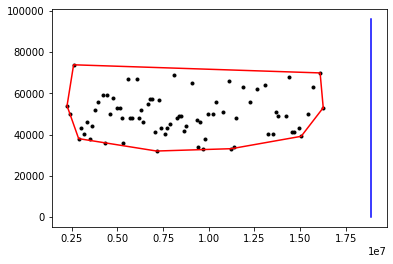

In [54]:

def split(u, v, points):
    # return points on left side of UV
    return [p for p in points if np.cross(p - u, v - u) < 0]
def extend(u, v, points):
    if not points:
        return []
    # find furthest point W, and split search to WV, UW
    w = min(points, key=lambda p: np.cross(p - u, v - u))
    p1, p2 = split(w, v, points), split(u, w, points)
    return extend(w, v, p1) + [w] + extend(u, w, p2)
def calc_convex_hull(points):
    # find two hull points, U, V, and split to left and right search
    u = min(points, key=lambda p: p[0])
    v = max(points, key=lambda p: p[0])
    left, right = split(u, v, points), split(v, u, points)
    
    # find convex hull on each side
    return [v] + extend(u, v, left) + \
           [u] + extend(v, u, right) + [v]

points = []
for i in range(0, len(time_msec)):
  points.append(np.array([time_msec[i], contraction_length_msec[i]]))
convex_hull = calc_convex_hull(points)
convex_hull_x =[]
convex_hull_y =[]
for point in convex_hull:
  convex_hull_x.append(point[0])
  convex_hull_y.append(point[1])
plt.plot(time_msec, contraction_length_msec, '.', color='black')
plt.plot(delivery_line_x, delivery_line_y, '-', color='blue')
plt.plot(convex_hull_x, convex_hull_y, '-', color='red')


This convex hull doesn't look like it will work either since the top of the hull hasn't considered any of the lower points of the top part which.
It would have worked much better if it had not been for that outlier at the beginning.